Episode 1, Reward: 13.0, Epsilon: 0.9950
Episode 2, Reward: 30.0, Epsilon: 0.9900
Episode 3, Reward: 34.0, Epsilon: 0.9851
Episode 4, Reward: 21.0, Epsilon: 0.9801
Episode 5, Reward: 23.0, Epsilon: 0.9752
Episode 6, Reward: 48.0, Epsilon: 0.9704
Episode 7, Reward: 30.0, Epsilon: 0.9655
Episode 8, Reward: 25.0, Epsilon: 0.9607
Episode 9, Reward: 14.0, Epsilon: 0.9559
Episode 10, Reward: 10.0, Epsilon: 0.9511
Episode 11, Reward: 84.0, Epsilon: 0.9464
Episode 12, Reward: 11.0, Epsilon: 0.9416
Episode 13, Reward: 11.0, Epsilon: 0.9369
Episode 14, Reward: 16.0, Epsilon: 0.9322
Episode 15, Reward: 13.0, Epsilon: 0.9276
Episode 16, Reward: 16.0, Epsilon: 0.9229
Episode 17, Reward: 49.0, Epsilon: 0.9183
Episode 18, Reward: 43.0, Epsilon: 0.9137
Episode 19, Reward: 15.0, Epsilon: 0.9092
Episode 20, Reward: 27.0, Epsilon: 0.9046
Episode 21, Reward: 13.0, Epsilon: 0.9001
Episode 22, Reward: 15.0, Epsilon: 0.8956
Episode 23, Reward: 30.0, Epsilon: 0.8911
Episode 24, Reward: 25.0, Epsilon: 0.8867
E

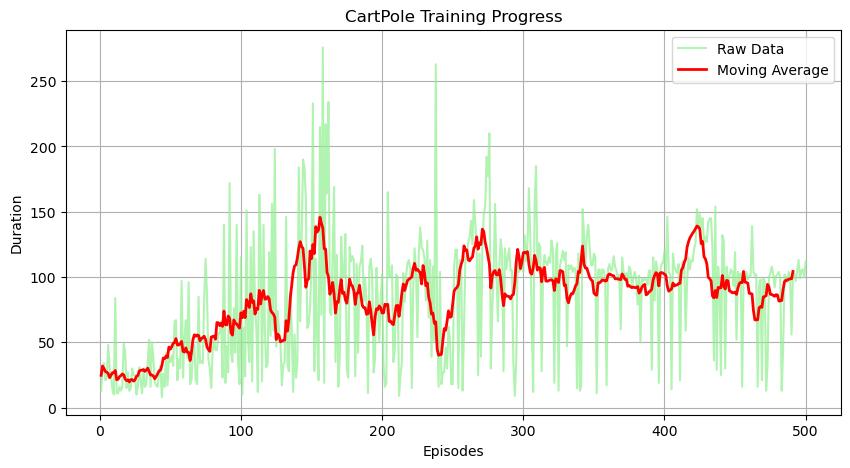

Total Reward in Simulation: 119.0


In [14]:
import gym
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque

# Initialize Gym environment
env = gym.make("CartPole-v1", render_mode="human")  # Use "human" mode for visualization
state_dim, action_dim = env.observation_space.shape[0], env.action_space.n

# Define DQN Model
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# Hyperparameters
EPISODES, GAMMA, LR = 500, 0.99, 1e-3
BATCH_SIZE, MEMORY_SIZE = 64, 10000
EPSILON, EPSILON_DECAY, MIN_EPSILON = 1.0, 0.995, 0.01

# Initialize policy and target networks
policy_net, target_net = DQN(state_dim, action_dim), DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())  # Sync networks
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = deque(maxlen=MEMORY_SIZE)

# Select action using epsilon-greedy strategy
def select_action(state, epsilon):
    return env.action_space.sample() if random.random() < epsilon else policy_net(torch.FloatTensor(state).unsqueeze(0)).argmax().item()

# Train DQN
durations_history = []
for episode in range(EPISODES):
    state, _ = env.reset()
    duration, total_reward, done = 0, 0, False

    while not done:
        action = select_action(state, EPSILON)
        next_state, reward, done, _, _ = env.step(action)
        memory.append((state, action, reward, next_state, done))
        state, duration, total_reward = next_state, duration + 1, total_reward + reward

        # Experience replay
        if len(memory) >= BATCH_SIZE:
            batch = random.sample(memory, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones).unsqueeze(1)

            # Q-learning update
            q_values = policy_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1, keepdim=True)[0].detach()
            target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    durations_history.append(duration)
    EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)  # Update epsilon
    if episode % 10 == 0: target_net.load_state_dict(policy_net.state_dict())  # Sync target net

    print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {EPSILON:.4f}")

# Save trained model
torch.save(policy_net.state_dict(), "cartpole_dqn.pth")

# Plot results - Updated Graph (Episode Duration over 500 Episodes)
plt.figure(figsize=(10, 5))

# Plot raw durations (green)
plt.plot(range(1, EPISODES+1), durations_history, color='lightgreen', alpha=0.7, label="Raw Data")

# Compute and plot moving average (Red)
window_size = 10
moving_avg = np.convolve(durations_history, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(1, len(moving_avg)+1), moving_avg, color='red', linewidth=2, label="Moving Average")

# Graph styling
plt.title("CartPole Training Progress")
plt.xlabel("Episodes")
plt.ylabel("Duration")
plt.legend()
plt.grid(True)
plt.show()

# Simulate trained model
policy_net.load_state_dict(torch.load("cartpole_dqn.pth", map_location="cpu"))
policy_net.eval()
state, _ = env.reset()
done, total_reward = False, 0

while not done:
    env.render()  # Show cart movement
    action = policy_net(torch.FloatTensor(state).unsqueeze(0)).argmax().item()
    state, reward, done, _, _ = env.step(action)
    total_reward += reward

env.close()
print(f"Total Reward in Simulation: {total_reward}")